###**Using PCA, T-SNE and UMAP to visualize the distribution of the data.**

**Note:** Only all images correctly recognised and predicted by the model

In [ ]:
pip install umap-learn

In [2]:
# Continue with regular imports
import os
from torch.utils.data import random_split
from tqdm.auto import tqdm
from torchvision import datasets, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from pathlib import Path


**Get data from drift_modules helper functions**

In [3]:
#get helper functions
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the drift_modules directory and download it from GitHub if it doesn't work
try:
    from drift_modules import get_data, data_setup,plot,load_model,model_data, get_correct_preds_df
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/AbigailUchennaNkama/model-drift-simulation
    !mv model-drift-simulation/drift_modules .
    !mv model-drift-simulation/model .
    !rm -rf model-drift-simulation
    from drift_modules import get_data, data_setup, plot, load_model, model_data, get_correct_preds_df



Using downloaded and verified file: ./cifar10.tgz 


In [4]:
manual_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Get all correctly predicted images**

In [10]:
#get train and val dataloaders and class_names
dataloaders, class_names, dataset_sizes = data_setup.create_dataloaders()

model_ft2 = load_model.load_custom_pretrained_model('/content/model/cifar_model .pth',10) # fetch model

data_dir = "/content/data/cifar10" #get image paths
test_data_paths = list(Path(data_dir+"/test").glob("*/*.png"))
test_labels = [path.parent.stem for path in test_data_paths]

print("[INFO]")
print("fetching all correct preds...")
test_pred_dicts = get_correct_preds_df.pred_and_store(test_paths=test_data_paths,
                                 model=model_ft2,
                                 transform=manual_transforms,
                                 class_names=class_names,
                                 device=device)

import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
correct_preds = test_pred_df[test_pred_df["correct"]==True]
#number of correct predictions
correct_pred_img = list(correct_preds["image_path"])
print(f"number of correctly predicted images: {len(correct_pred_img)}")

[INFO]
fetching all correct preds...


  0%|          | 0/10000 [00:00<?, ?it/s]

number of correctly predicted images: 9457


**Get all preds into folders and subfolders**

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
from timeit import default_timer as timer
from torch.types import Device
from shutil import copy
from collections import defaultdict
import pandas as pd
from pathlib import Path
correct_pred_img = list(correct_preds["image_path"])
correct_pred_img = [str(path) for path in correct_pred_img]

# Create a defaultdict to store lists of file paths for each category
category_lists = defaultdict(lambda: [])

# Loop through the file paths and categorize them
for file_path in correct_pred_img:
    # Split the file path using '/'
    parts = file_path.split('/')
    # The category is the second-to-last part of the path
    category = parts[-2]
    # Append the file path to the corresponding category list
    category_lists[category].append(file_path)

output_dir = '/content/data/cifar10/correct_test/'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Create a folder for each category and copy the images with category name in the filename
for category, paths in category_lists.items():
    category_dir = os.path.join(output_dir, category)
    os.makedirs(category_dir, exist_ok=True)
    for path in paths:
        # Get the filename from the path
        filename = os.path.basename(path)
        # Modify the filename to include the category name
        new_filename = f"{category}_{filename}"
        # Copy the image to the category folder with the new filename
        copy(path, os.path.join(category_dir, new_filename))

print("Folders created and images organized.")

Folders created and images organized.


**Plot and view some images**

[INFO] length of dataloader: 148
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


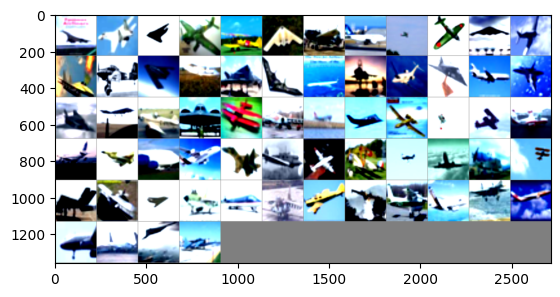

In [7]:
dataloader, class_names = model_data.get_data()
print(f"[INFO] length of dataloader: {len(dataloader)}")
print(class_names)

plot.show_image(dataloader)

**View data distribution using PCA, T-SNE and UMAP**

In [9]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

transform = transforms.Compose([transforms.ToTensor()])

# Define the path dataset directory
data_dir = "/content/data/cifar10"
model_dataset = ImageFolder(data_dir+"/correct_test", transform=transform)

# Extract images and labels from the dataset
images = torch.stack([img for img, _ in model_dataset])
labels = np.array([label for _, label in model_dataset])

# Define class names
class_names = model_dataset.classes

# Perform dimensionality reduction (PCA, t-SNE, UMAP)
n_components = 2

# PCA
pca = PCA(n_components=n_components)
reduced_data_pca = pca.fit_transform(images.view(len(labels), -1).numpy())

# t-SNE
tsne = TSNE(n_components=n_components, perplexity=30, n_iter=300)
reduced_data_tsne = tsne.fit_transform(images.view(len(labels), -1).numpy())

# UMAP
umap_model = umap.UMAP(n_components=n_components, n_neighbors=30, min_dist=0.1)
reduced_data_umap = umap_model.fit_transform(images.view(len(labels), -1).numpy())

# Create DataFrames for Plotly
df_pca = pd.DataFrame({'PCA1': reduced_data_pca[:, 0], 'PCA2': reduced_data_pca[:, 1], 'Labels': labels})
df_tsne = pd.DataFrame({'t-SNE1': reduced_data_tsne[:, 0], 't-SNE2': reduced_data_tsne[:, 1], 'Labels': labels})
df_umap = pd.DataFrame({'UMAP1': reduced_data_umap[:, 0], 'UMAP2': reduced_data_umap[:, 1], 'Labels': labels})

# Map class labels to class names
df_pca['ClassNames'] = [class_names[label] for label in df_pca['Labels']]
df_tsne['ClassNames'] = [class_names[label] for label in df_tsne['Labels']]
df_umap['ClassNames'] = [class_names[label] for label in df_umap['Labels']]

# Create Plotly figures for PCA, t-SNE, and UMAP
fig_pca = px.scatter(df_pca, x='PCA1', y='PCA2', color='ClassNames', title='PCA Visualization of Custom Dataset')
fig_tsne = px.scatter(df_tsne, x='t-SNE1', y='t-SNE2', color='ClassNames', title='t-SNE Visualization of Custom Dataset')
fig_umap = px.scatter(df_umap, x='UMAP1', y='UMAP2', color='ClassNames', title='UMAP Visualization of Custom Dataset')

# Display the figures
fig_pca.show()
fig_tsne.show()
fig_umap.show()
